In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import mannwhitneyu, ttest_ind
from dataclasses import dataclass

Цель исследования: рассмотреть подходы для сравнения средних двух выборок, оценить ошибки I и II рода, проверить сонаправленность разности средних и проверяемых гипотез
Сравниваться будут: 
1) t-test Уэлча
2) бакетный t-test Уэлча
3) бакетный тест Манна-Уитни

Проверим как на метриках конверсии, так и на непрерывных метриках. Если результаты на этих данных будут многообещающими, то проверим на метриках отношений.

Проверка будет произведена на 100, 10_000 и 1_000_000 наблюдениях

In [74]:
@dataclass
class StatTestCalc:
    n: int
    n_bucket: int
    distribution: str  # 'normal', 'exp', ...
    p: float = None
    mean: float = None
    std: float = None

    '''
    n: кол-во наблюдений
    n_bucket: число бакетов на все наблюдения
    distribution: распределение выборки
    mean: среднее значение выборки
    sqrt: стандартное отклонение выборки
    '''

    def gen_dist(self) -> pd.DataFrame:
        if self.distribution == 'normal':
            if self.mean is None or self.std is None:
                raise ValueError("укажите mean и std для нормального распределения")
            data = np.random.normal(self.mean, self.std, size=self.n)

        elif self.distribution == 'exp':
            if self.mean is None:
                raise ValueError("укажите mean для экспоненциального распределения")
            data = np.random.exponential(scale=self.mean, size=self.n)

        else:
                raise ValueError(f"Unknown distribution: {self.distribution}")
        df = pd.DataFrame({'gmv': data})
        df['gmv'] = df['gmv'].apply(lambda x: 0 if x < 30 else x)
        df['cr'] = df['gmv'].apply(lambda x: 1 if x > 0 else 0)
        return df

    def get_group(self, df) -> pd.DataFrame:
        df['ab_group'] = df.apply(lambda x: np.random.choice(['a', 'b'], p=[0.5, 0.5]), axis=1)
        return df
    
    def get_bucket(self, df) -> pd.DataFrame:
        df['bucket'] = df.apply(lambda x: np.random.choice(np.arange(0, self.n_bucket)), axis=1)
        return df
    
    def collect_stats(self, df, metric) -> dict:
        a_df = df[df['ab_group'] == 'a']
        b_df = df[df['ab_group'] == 'b']

        a_buckets = a_df.groupby('bucket', as_index=False).agg(mean_buck=(metric, 'mean'))
        b_buckets = b_df.groupby('bucket', as_index=False).agg(mean_buck=(metric, 'mean'))

        diff_abs = b_df[metric].mean() - a_df[metric].mean()
        diff_rel = (b_df[metric].mean() - a_df[metric].mean()) / a_df[metric].mean() * 100

        diff_abs_bucket = b_buckets['mean_buck'].mean() - a_buckets['mean_buck'].mean()
        diff_rel_bucket = (b_buckets['mean_buck'].mean() - a_buckets['mean_buck'].mean()) / a_buckets['mean_buck'].mean() * 100

        ratio_diffs = diff_rel_bucket / diff_rel

        pval_ttest = ttest_ind(a=a_df[metric],
                               b=b_df[metric],
                               equal_var=False,
                               alternative="two-sided"
                               )[1]
        pval_ttest_bucket = ttest_ind(a=a_buckets['mean_buck'],
                                      b=b_buckets['mean_buck'],
                                      equal_var=False,
                                      alternative="two-sided"
                                    )[1]
        pval_mw = mannwhitneyu(x=a_buckets['mean_buck'],
                               y=b_buckets['mean_buck'],
                               alternative="two-sided")[1]
        
        return {'diff_abs': diff_abs,
                'diff_rel': diff_rel,
                'pval_ttest': pval_ttest,
                'diff_abs_bucket': diff_abs_bucket,
                'diff_rel_bucket': diff_rel_bucket,
                'pval_ttest_bucket': pval_ttest_bucket,
                'pval_mw_bucket': pval_mw,
                'ratio_diffs': ratio_diffs
                }
    

    def plot_stats(self, df, metric, n, alpha=0.05):

        sns.set(style="whitegrid", font_scale=1.2)

        fig, axes = plt.subplots(3, 3, figsize=(18, 12))
        fig.suptitle(f'Метрика {metric}, число итераций {n}, число наблюдений {self.n}, число бакетов {self.n_bucket}', fontsize=22)

        fpr_ttest = round((df['pval_ttest'] < alpha).mean(), 3)
        fpr_ttest_b = round((df['pval_ttest_bucket'] < alpha).mean(), 3)
        fpr_mw_b = round((df['pval_mw_bucket'] < alpha).mean(), 3)

        sns.histplot(ax=axes[0, 0], x=df['pval_ttest'], stat='probability', bins=20)
        axes[0, 0].set_xlabel('p-value t-test', fontsize=14)
        axes[0, 0].set_title(f't-test, FPR={fpr_ttest}', fontsize=18)

        sns.histplot(ax=axes[0, 1], x=df['pval_ttest_bucket'], stat='probability', bins=20)
        axes[0, 1].set_xlabel('p-value t-test_bucket', fontsize=14)
        axes[0, 1].set_title(f'бакетный t-test, FPR={fpr_ttest_b}', fontsize=18)

        sns.histplot(ax=axes[0, 2], x=df['pval_mw_bucket'], stat='probability', bins=20)
        axes[0, 2].set_xlabel('p-value mw_bucket', fontsize=14)
        axes[0, 2].set_title(f'бакетный MW, FPR={fpr_mw_b}', fontsize=18)

        sns.scatterplot(ax=axes[1, 0], x=df['pval_ttest'], y=df['pval_ttest_bucket'])
        axes[1, 0].set_xlabel('t-test', fontsize=13)
        axes[1, 0].set_ylabel('t-test_bucket', fontsize=13)
        axes[1, 0].set_title('Сравнение: t-test vs bucket', fontsize=17)

        sns.scatterplot(ax=axes[1, 1], x=df['pval_ttest'], y=df['pval_mw_bucket'])
        axes[1, 1].set_xlabel('t-test', fontsize=13)
        axes[1, 1].set_ylabel('mw_bucket', fontsize=13)
        axes[1, 1].set_title('Сравнение: t-test vs bucket MW', fontsize=17)

        sns.scatterplot(ax=axes[1, 2], x=df['pval_mw_bucket'], y=df['pval_ttest_bucket'])
        axes[1, 2].set_xlabel('mw_bucket', fontsize=13)
        axes[1, 2].set_ylabel('t-test_bucket', fontsize=13)
        axes[1, 2].set_title('Сравнение: bucket MW vs bucket t-test', fontsize=17)

        sns.scatterplot(ax=axes[2, 0], x=df['diff_rel'], y=df['diff_rel_bucket'])
        axes[2, 0].set_xlabel('diff_rel', fontsize=13)
        axes[2, 0].set_ylabel('diff_rel_bucket', fontsize=13)
        axes[2, 0].set_title('Относительный эффект: обычный и бакетный, %', fontsize=17)

        sns.scatterplot(ax=axes[2, 1], x=df['diff_abs'], y=df['diff_abs_bucket'])
        axes[2, 1].set_xlabel('diff_abs', fontsize=13)
        axes[2, 1].set_ylabel('diff_abs_bucket', fontsize=13)
        axes[2, 1].set_title('Абсолютный эффект: обычный и бакетный', fontsize=17)

        sns.histplot(ax=axes[2, 2], x=df['ratio_diffs'], stat='probability', bins=20)
        axes[2, 2].set_xlabel('ratio_diffs', fontsize=14)
        axes[2, 2].set_title(f'''Отношение бакетного эффекта к истинному, разы.
среднее {round(df['ratio_diffs'].mean(), 2)}, медиана {round(df['ratio_diffs'].median(), 3)}''', fontsize=18)

        plt.tight_layout(rect=[0, 0, 1, 0.95])

# АА тесты
## непрерывные метрики
На примере ARPU, сгенерированного через экспоненциальное распределение + зануление значений < 30 оценим распределение pvalue, сонаправленность эффектов и гипотез. Так же оценим те же характеристики при добавлении выброса

In [17]:
iterations = 2_000

100%|██████████| 2000/2000 [01:44<00:00, 19.07it/s]


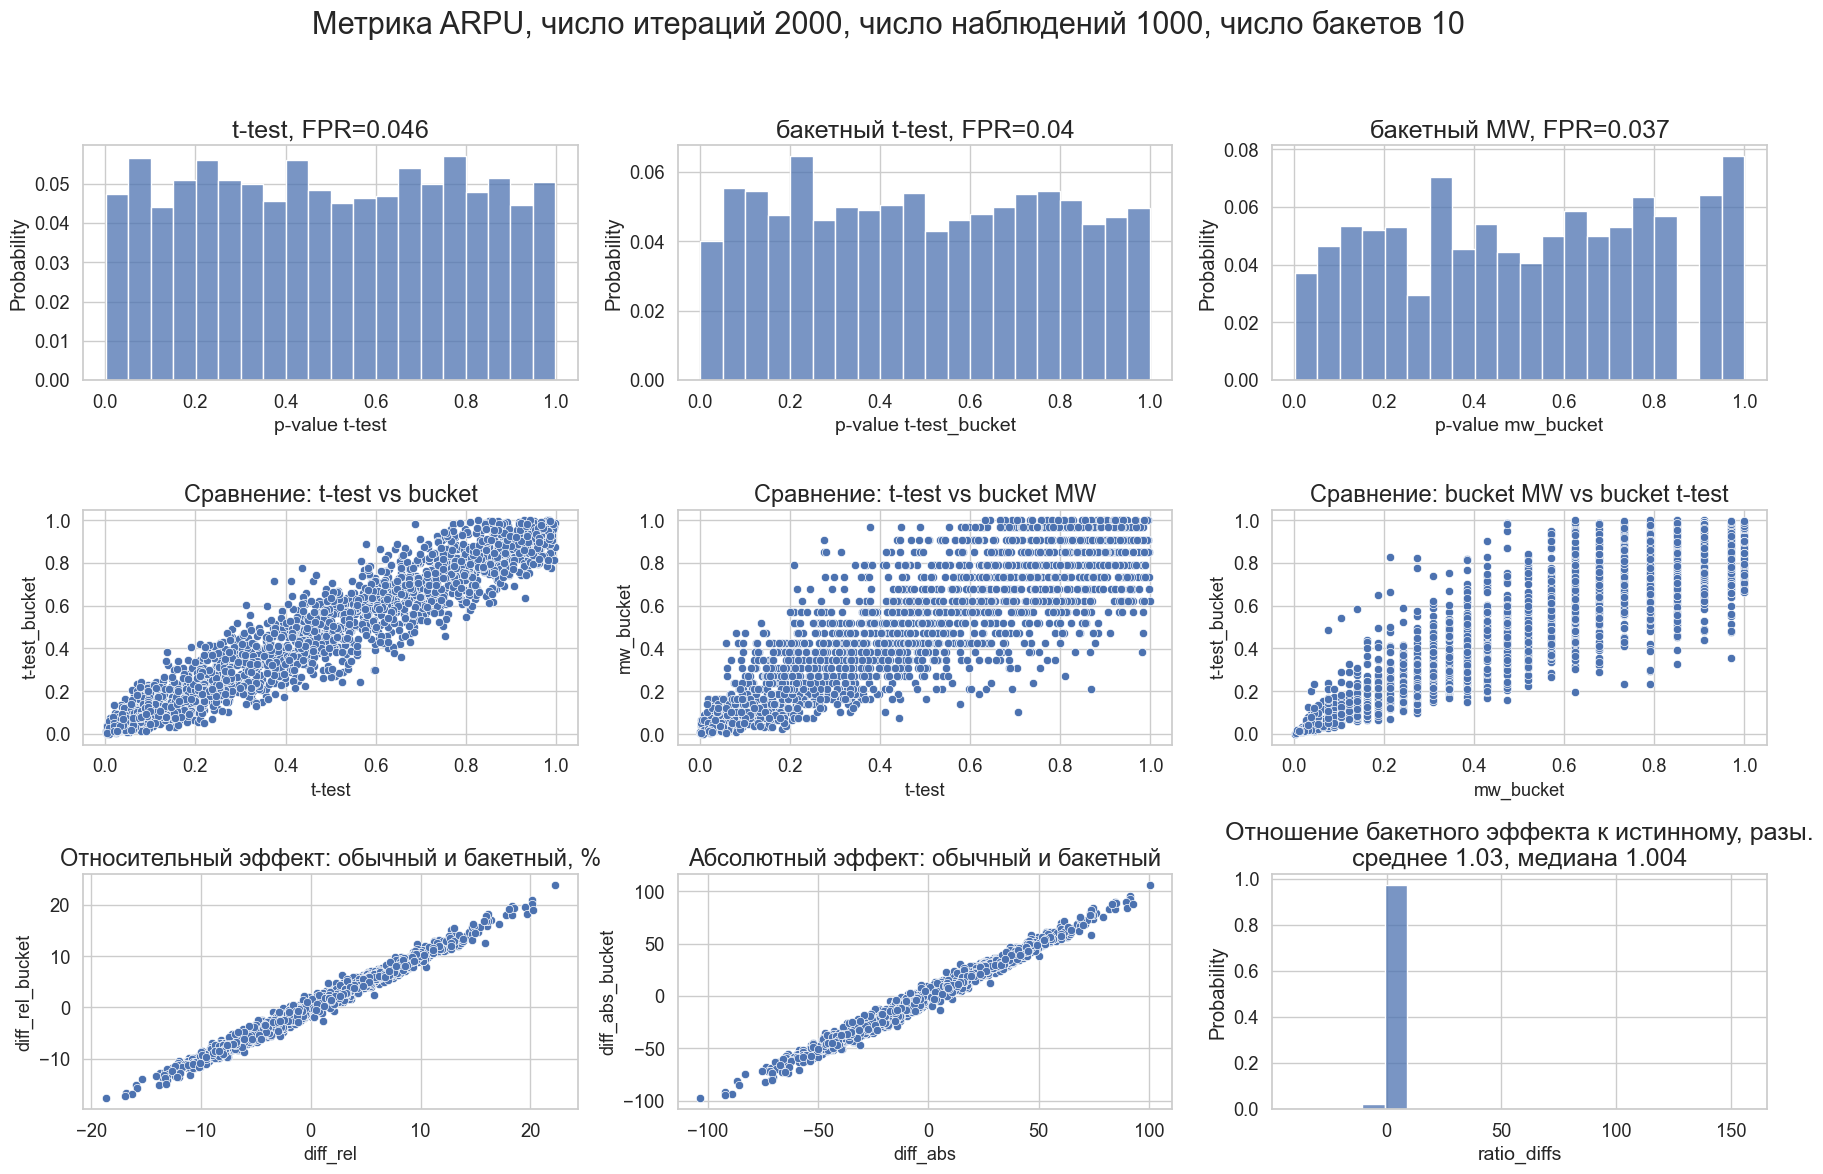

In [18]:
test_calc = StatTestCalc(n=1000, n_bucket=10, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

Увеличим число наблюдений и бакетов

100%|██████████| 2000/2000 [13:37<00:00,  2.45it/s]


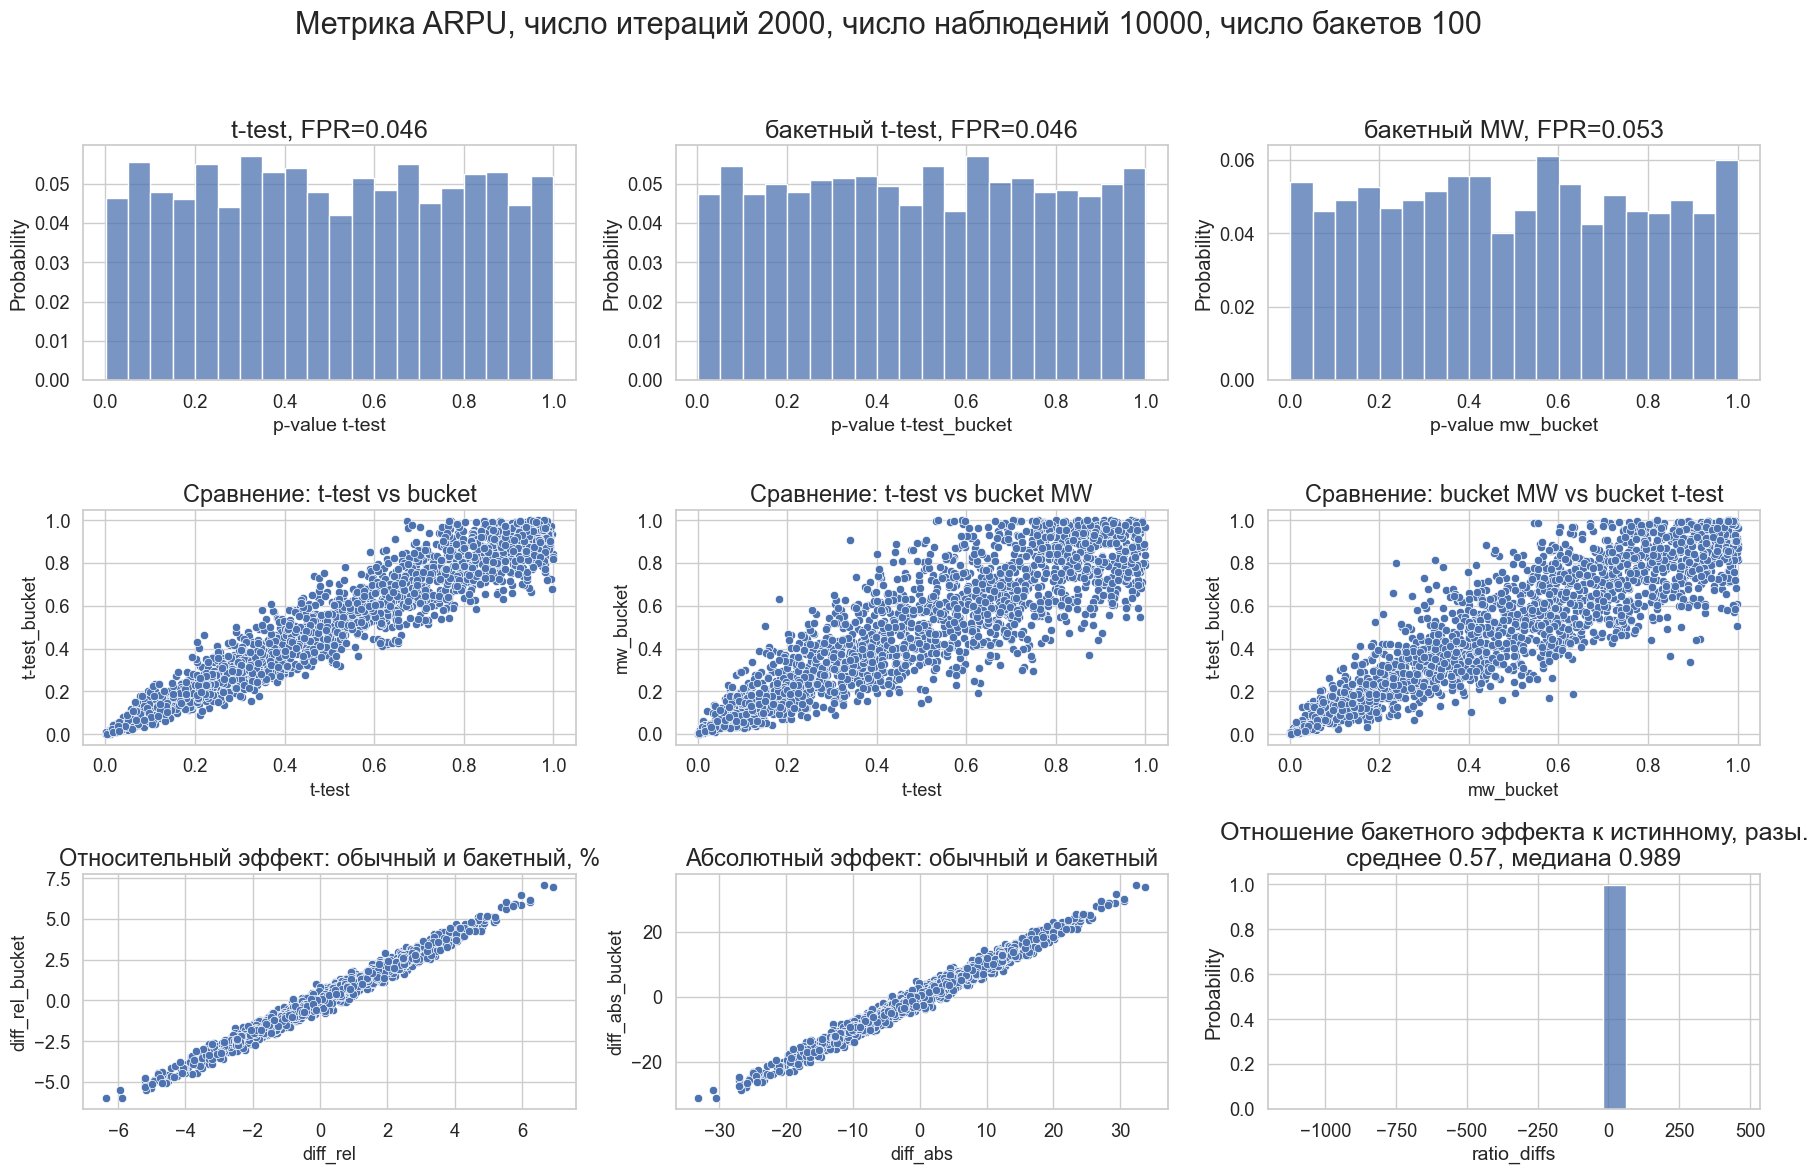

In [19]:
test_calc = StatTestCalc(n=10_000, n_bucket=100, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

100%|██████████| 2000/2000 [2:14:18<00:00,  4.03s/it]  


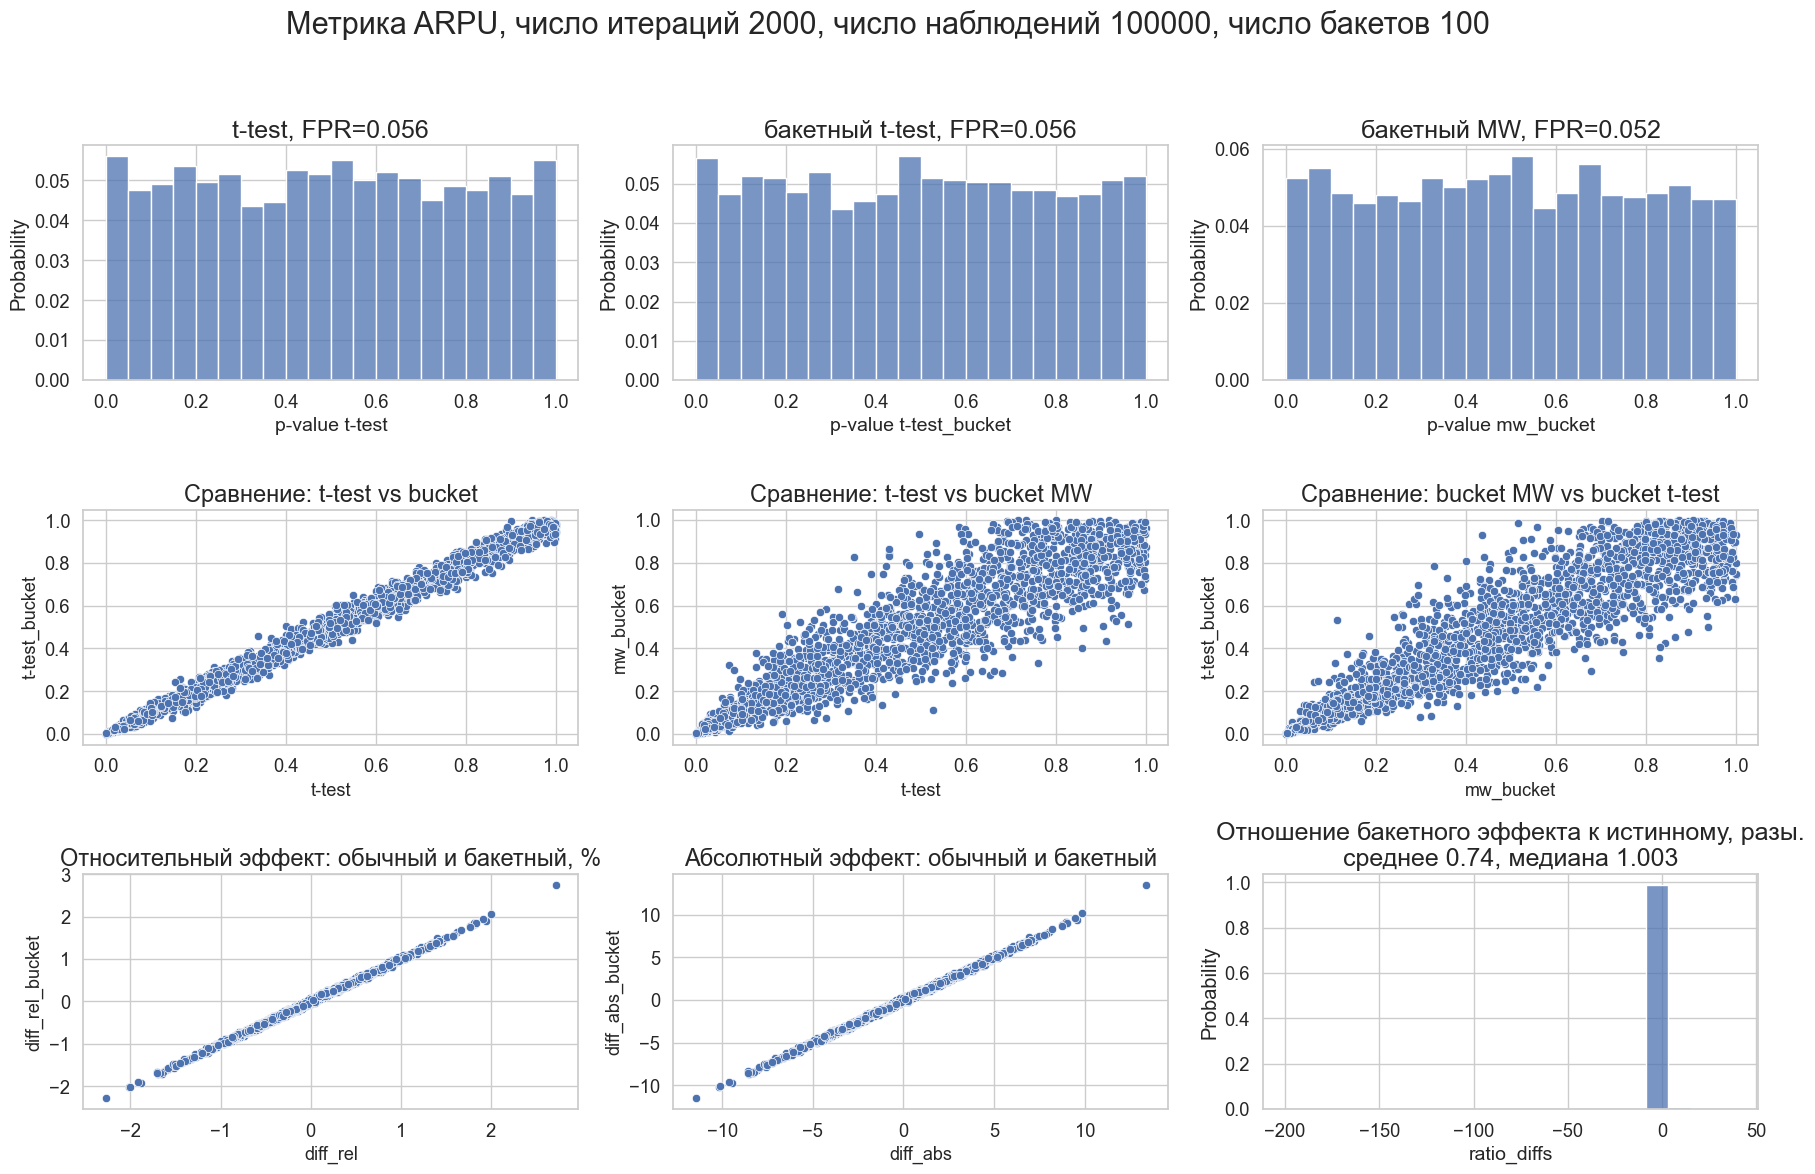

In [20]:
test_calc = StatTestCalc(n=100_000, n_bucket=100, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

увеличим число бакетов в 2 раза и посмотрим, есть ли отличия

100%|██████████| 2000/2000 [2:59:53<00:00,  5.40s/it]   


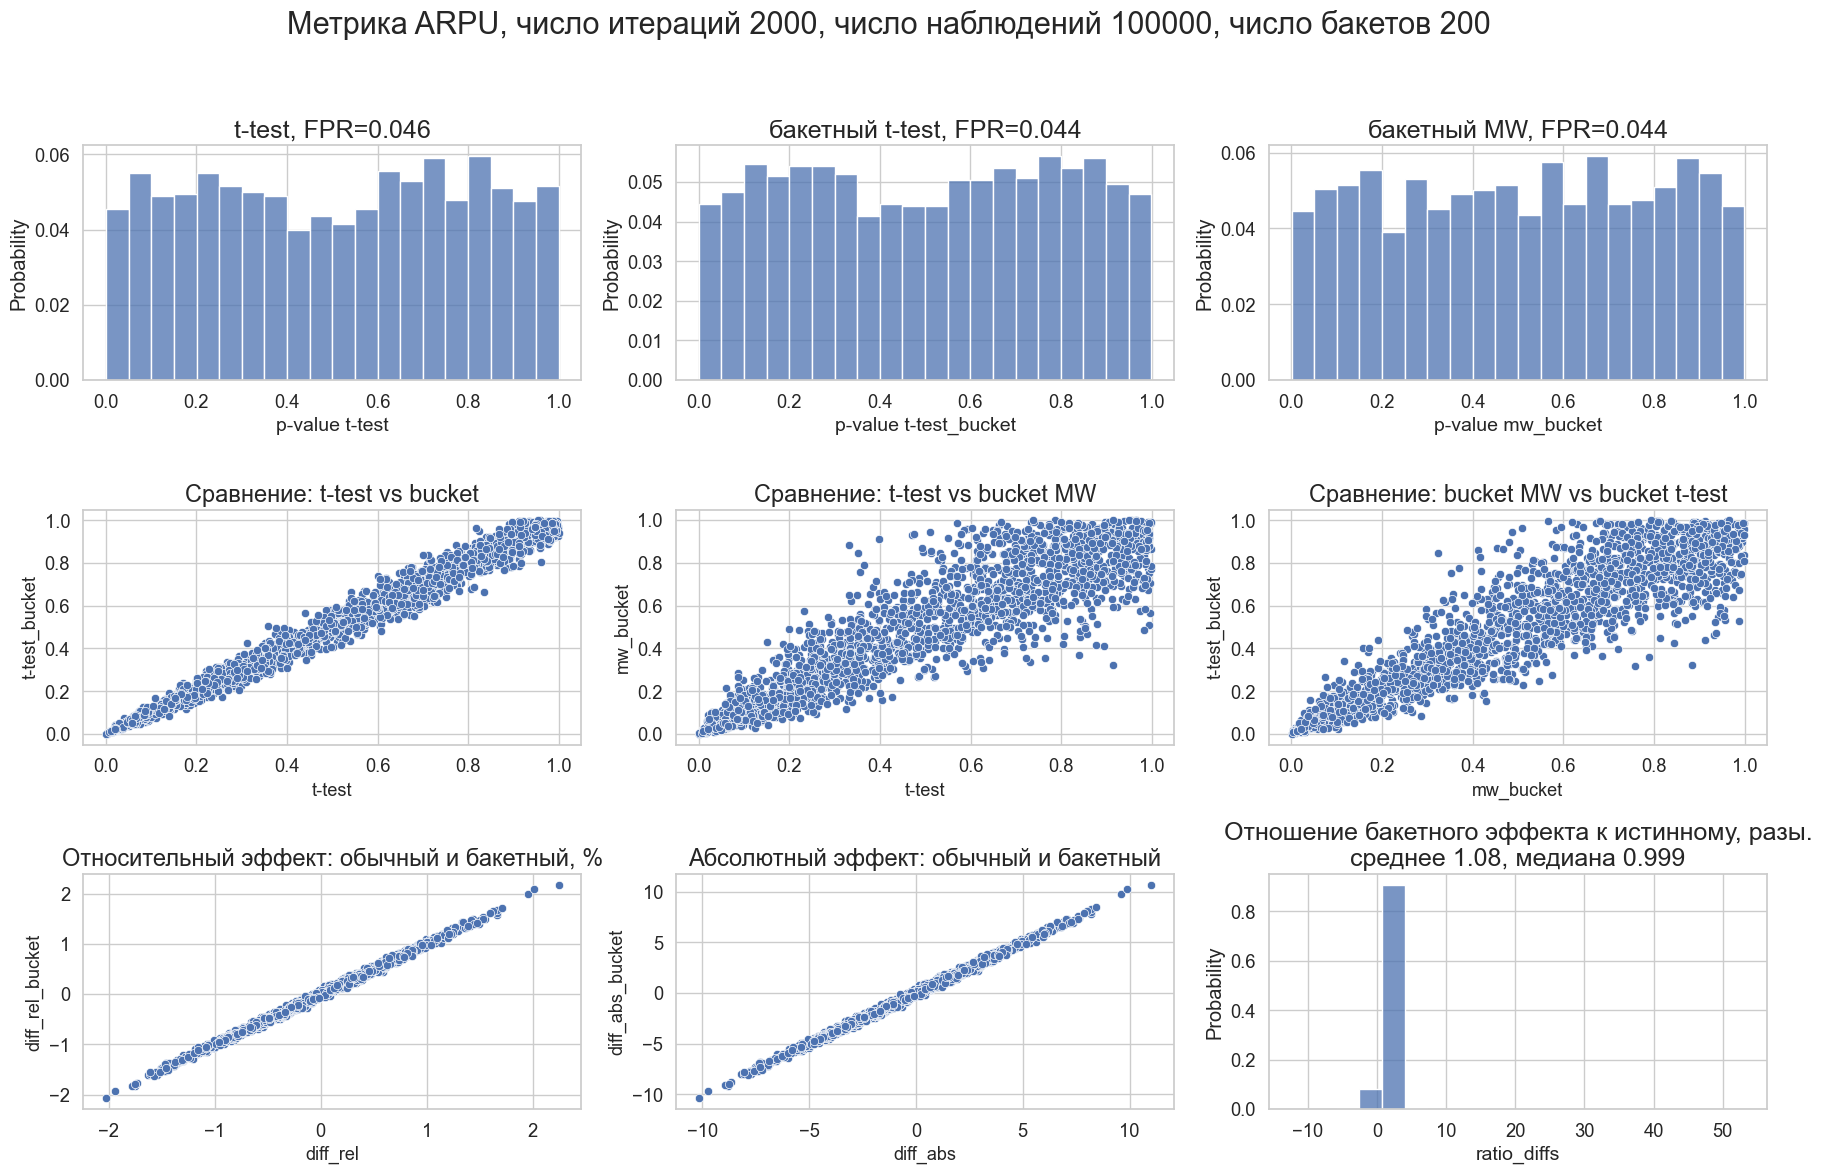

In [21]:
test_calc = StatTestCalc(n=100_000, n_bucket=200, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

при увеличении числа бакетов сонаправленность по p-value и разницы средним ухудшилась между бакетным t-тестом и обычным.еще раз увеличим число бакетов

100%|██████████| 2000/2000 [10:43:22<00:00, 19.30s/it]      


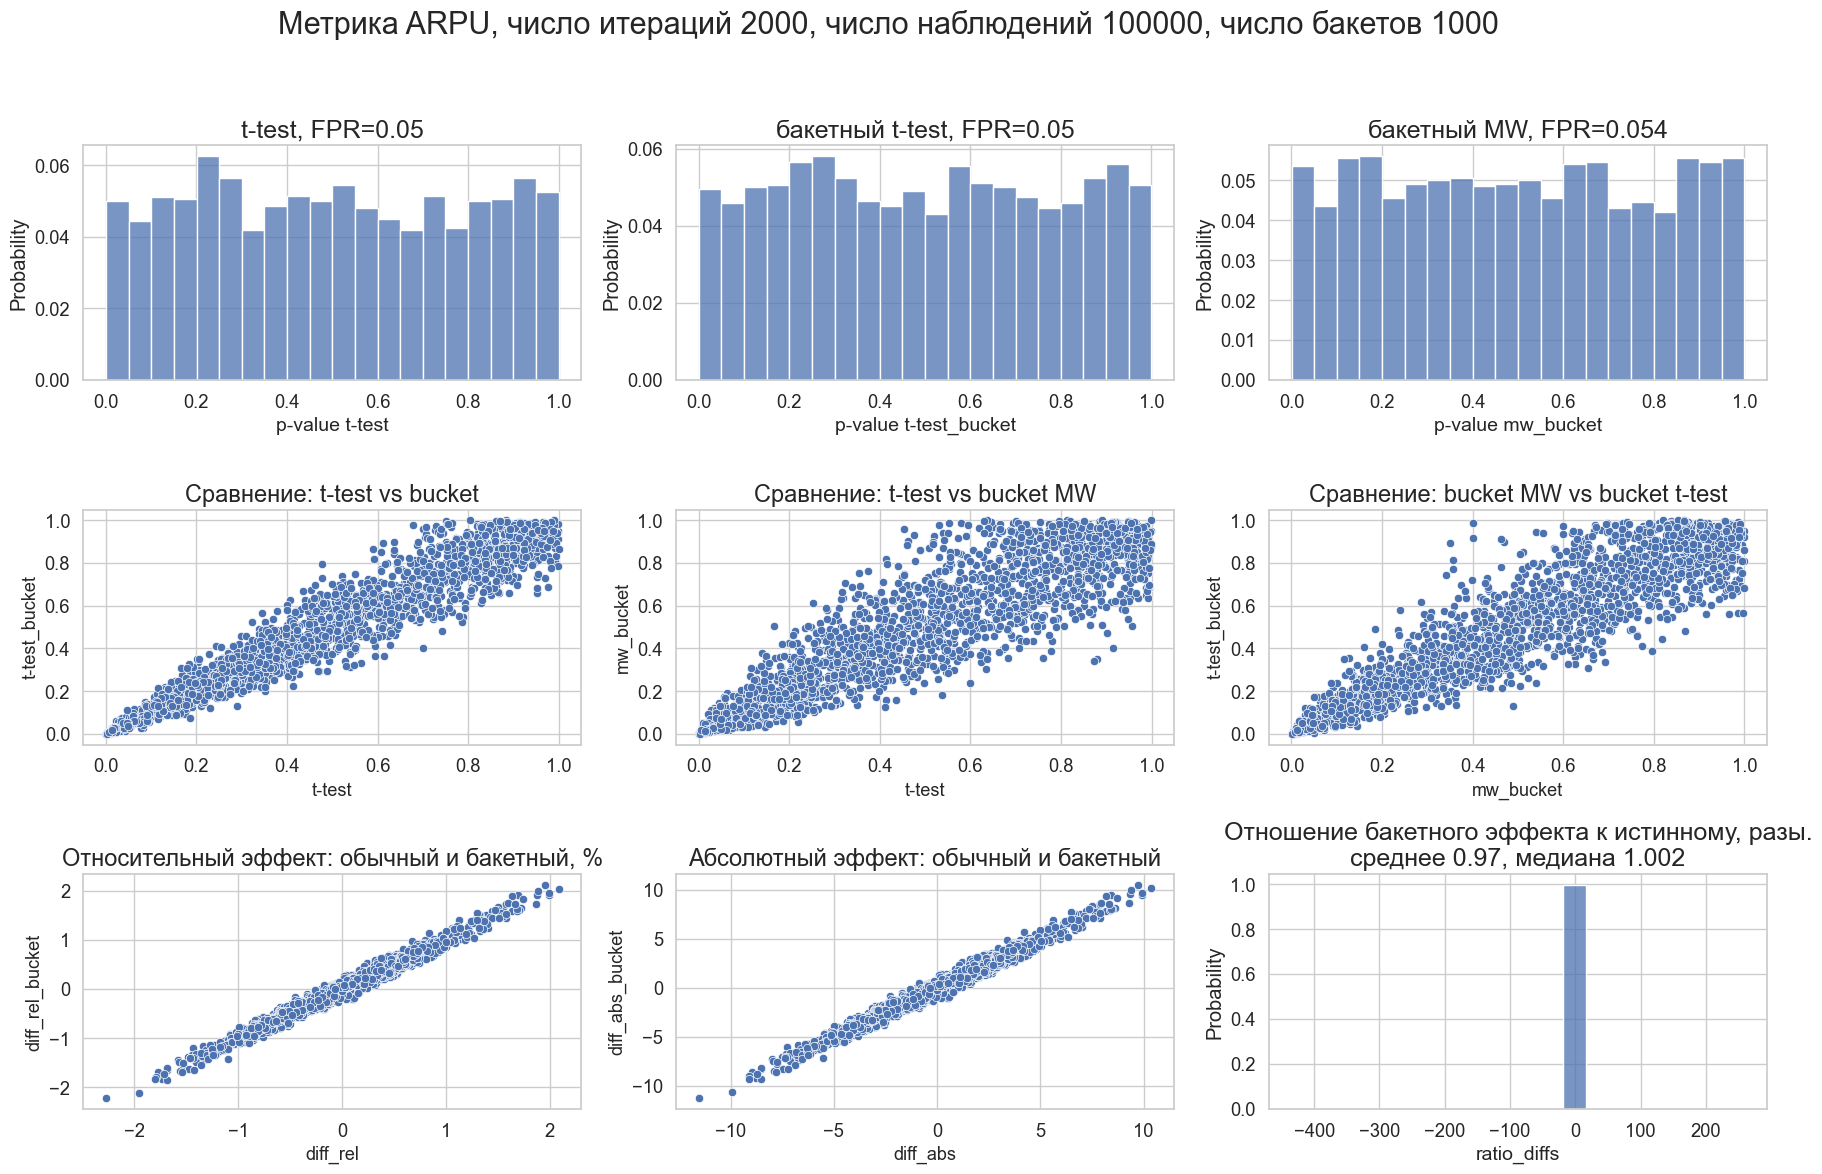

In [22]:
test_calc = StatTestCalc(n=100_000, n_bucket=1_000, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

### Промежуточные итоги:
- FPR во всех способах расчета в рамках ожиданий в пределах нормы
- сонаправленности p-value не наблюдается, а значит проверяются разные гипотезы
- сонаправленность эффектов наблюдается, но неидеальная и в некоторых случаях (менее 10%) бакетный эффект сущесвтенно отличается от истинного
- бОльшее число бакетов не означает бОльшую сонаправленность по разнице средних и p-value

#### Добавим выброс, сломав обычный t-test, и повторим операции выше - смотрим устойчивость бакетных вариантов

<Axes: >

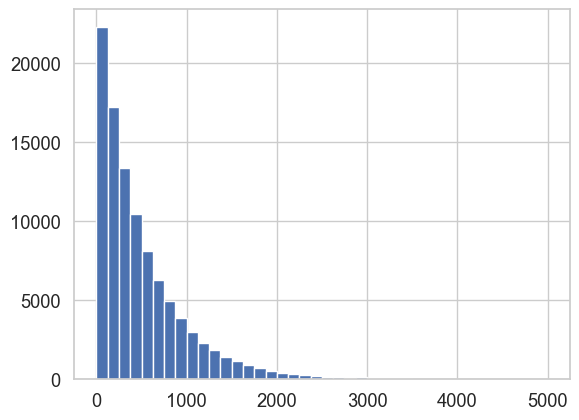

In [34]:
df['gmv'].hist(bins=40)

100%|██████████| 2000/2000 [2:16:53<00:00,  4.11s/it]  


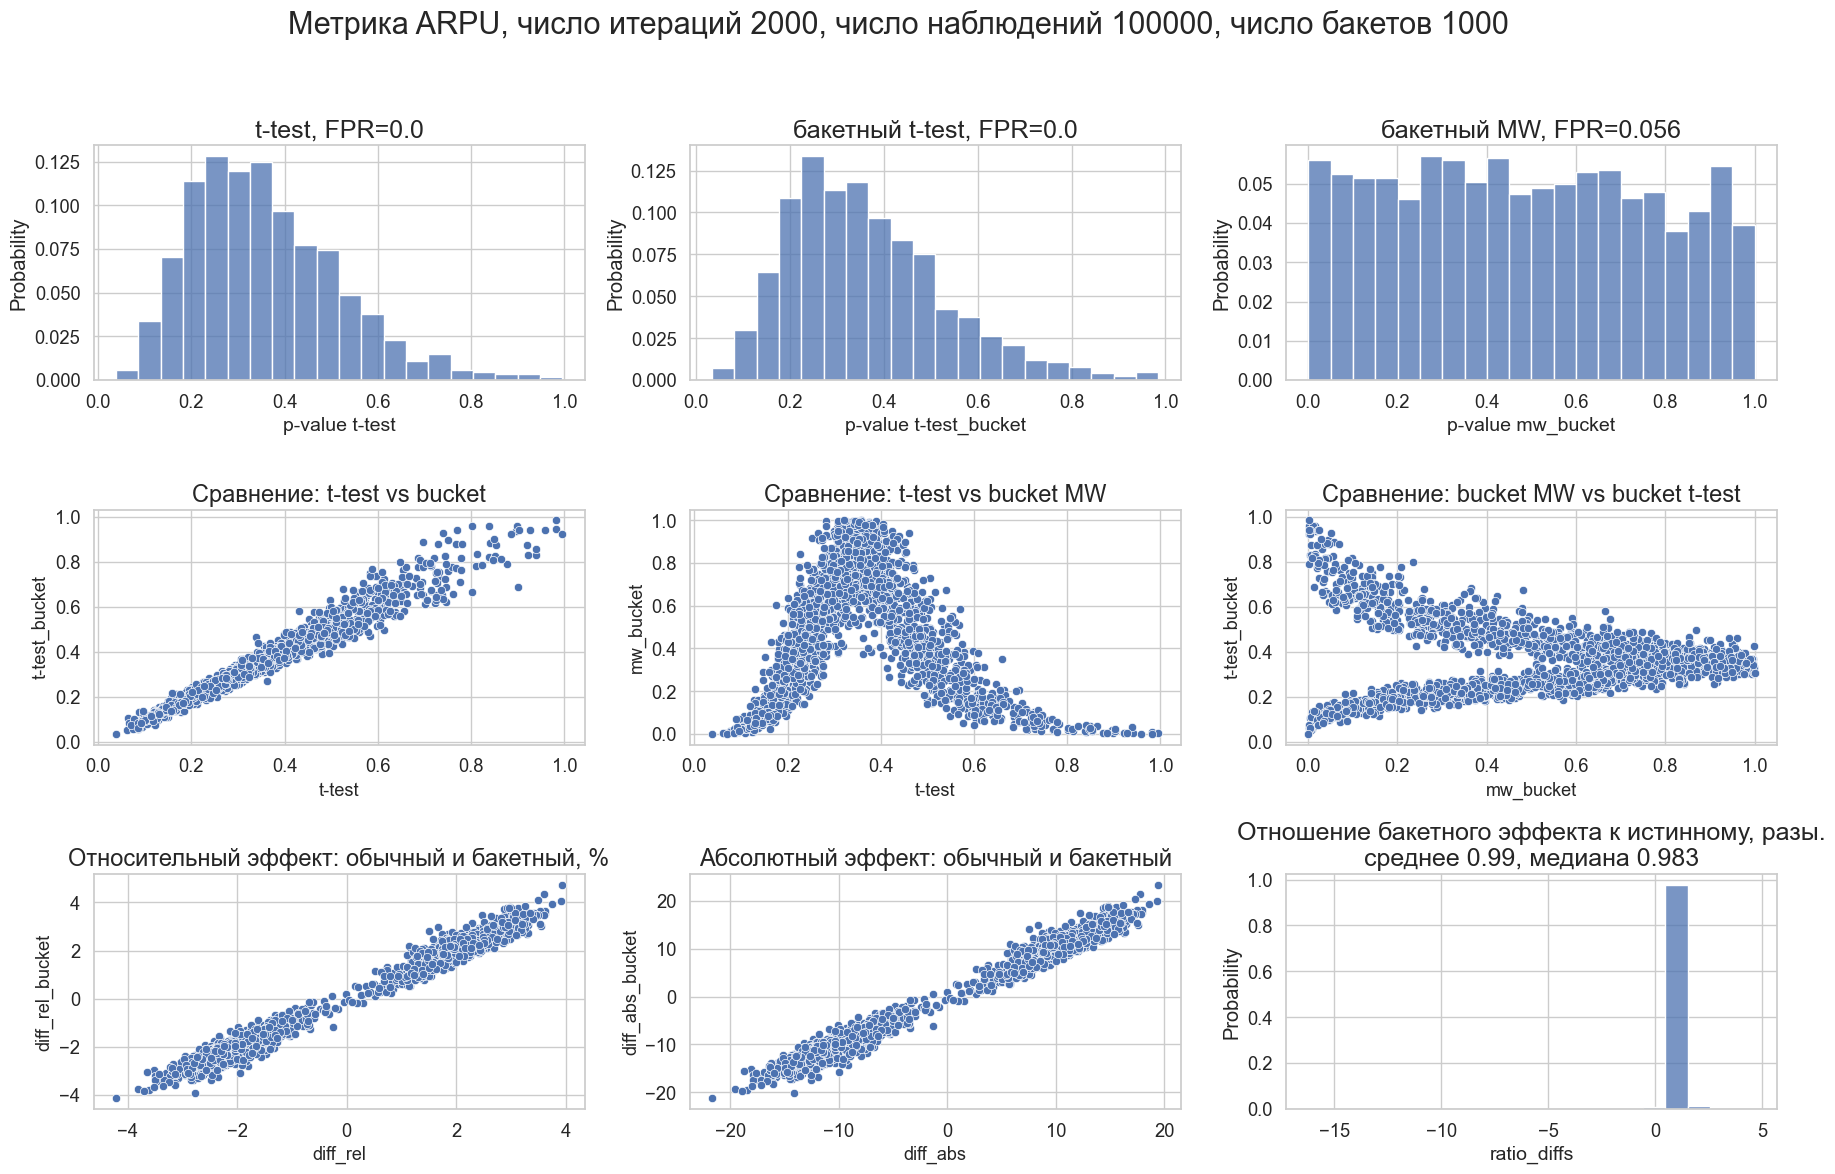

In [46]:
test_calc = StatTestCalc(n=100_000, n_bucket=1_000, distribution='exp', mean=500)
df = test_calc.gen_dist()
df.loc[len(df)] = [500000, True] # выброс

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

100%|██████████| 2000/2000 [2:15:07<00:00,  4.05s/it]  


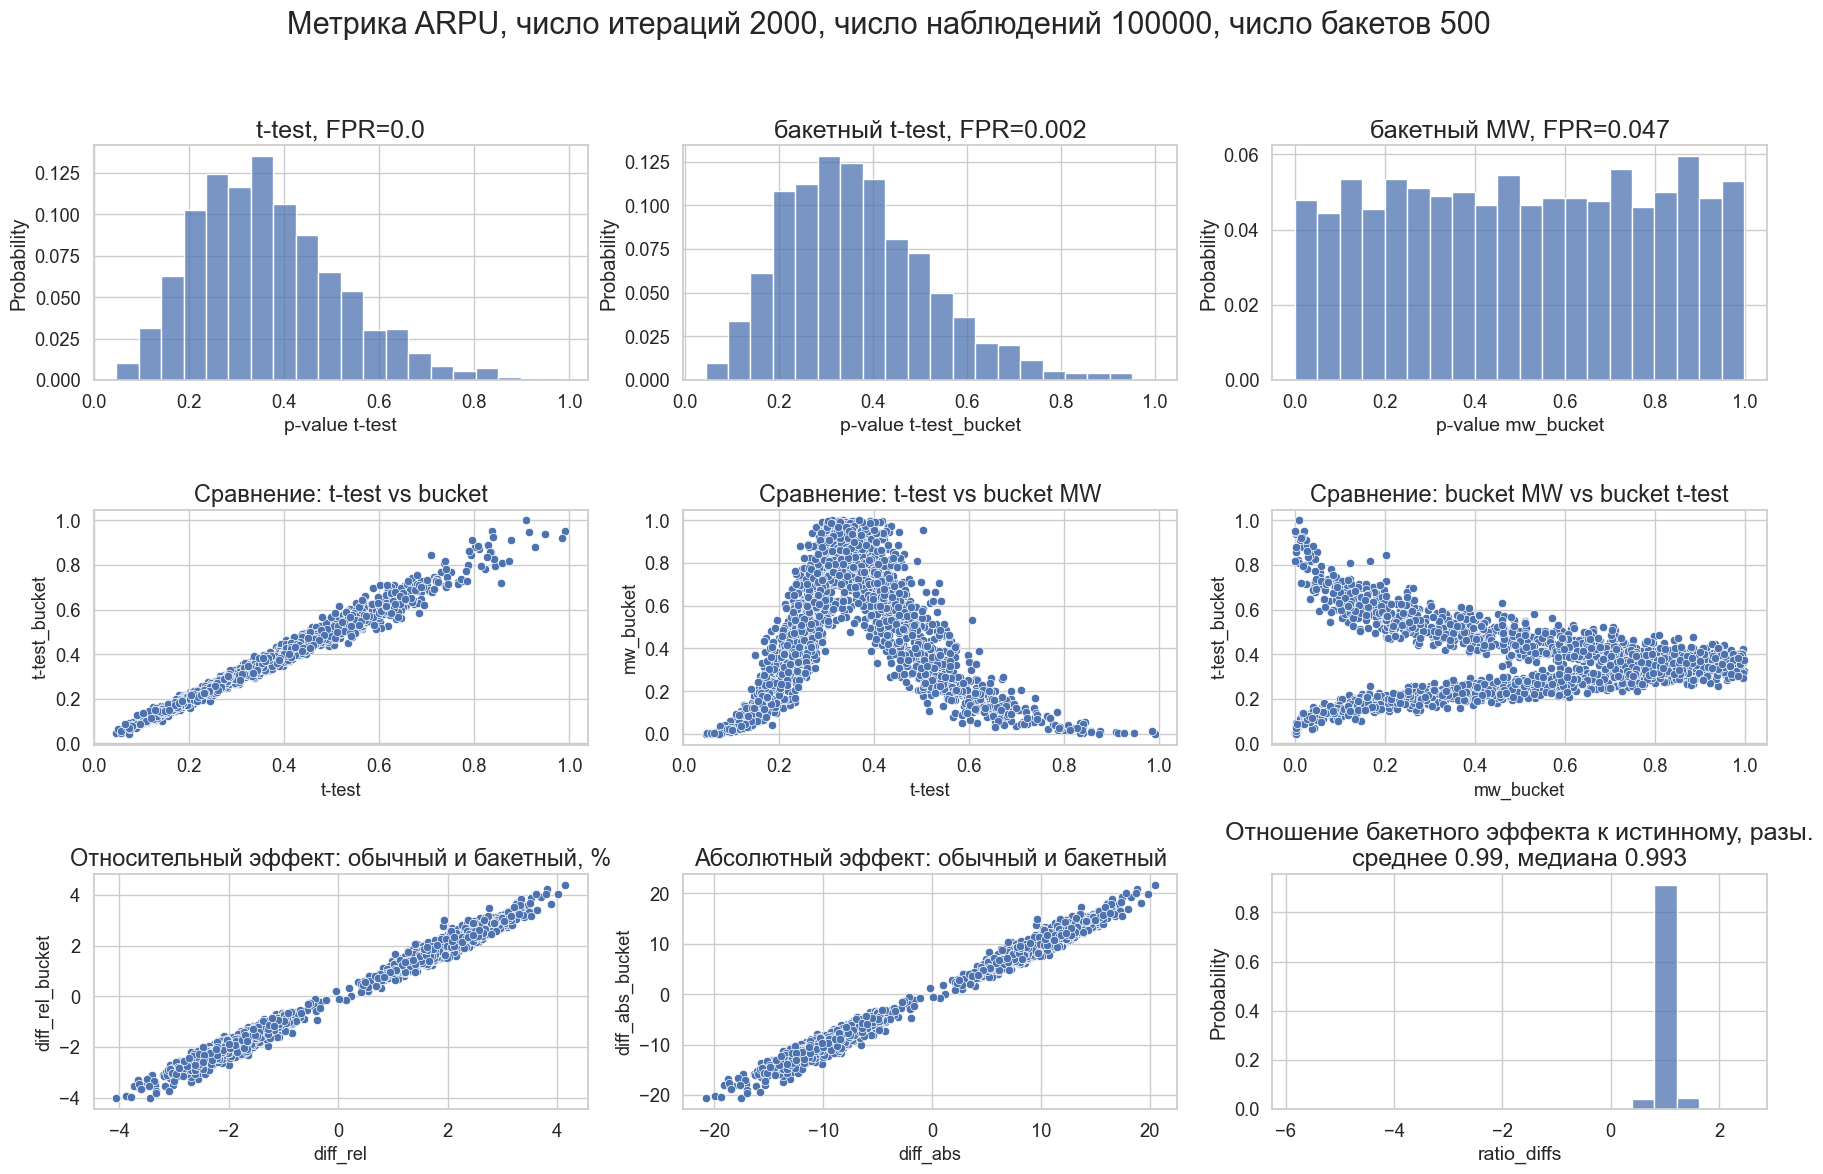

In [ ]:
# уменьшим число бакетов до 500
test_calc = StatTestCalc(n=100_000, n_bucket=500, distribution='exp', mean=500)
df = test_calc.gen_dist()
df.loc[len(df)] = [500000, True] # выброс

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

100%|██████████| 2000/2000 [3:48:35<00:00,  6.86s/it]  


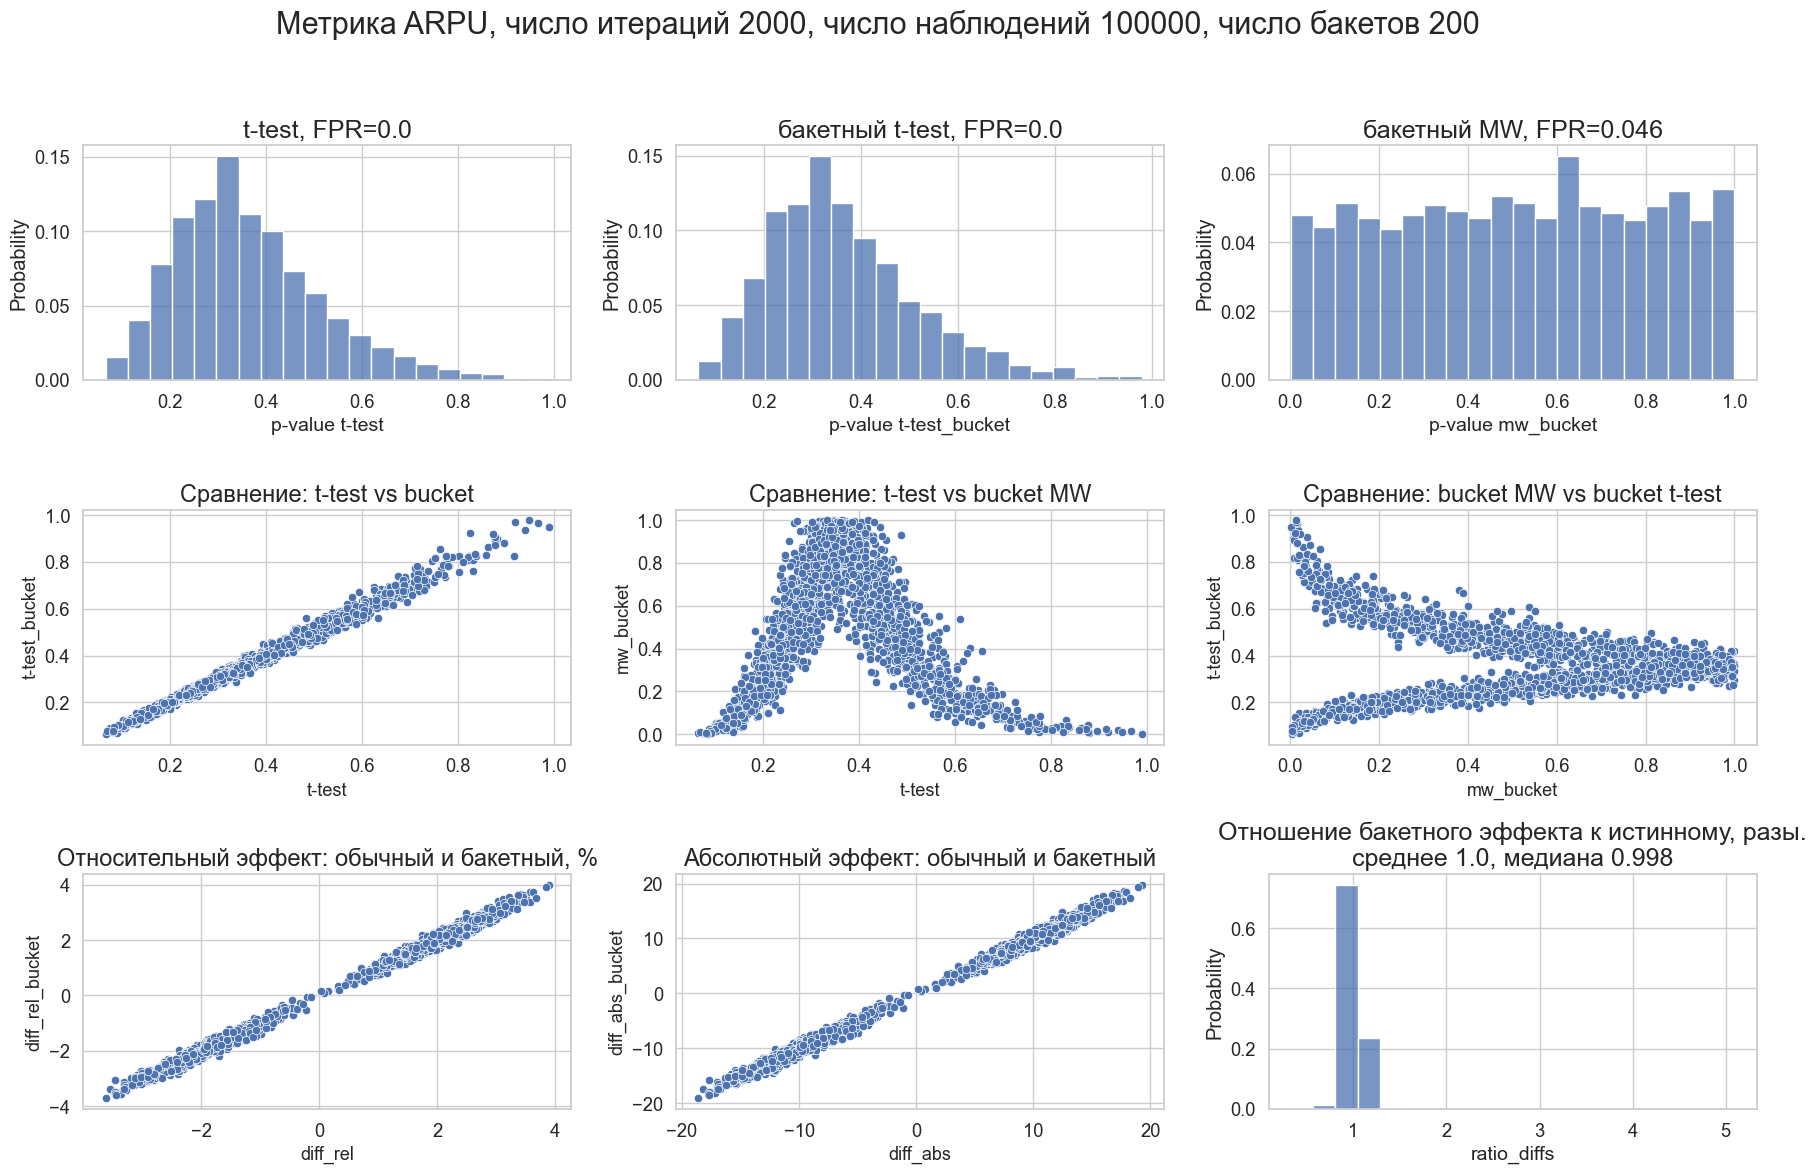

In [ ]:
# уменьшим число бакетов до 200
test_calc = StatTestCalc(n=100_000, n_bucket=200, distribution='exp', mean=500)
df = test_calc.gen_dist()
df.loc[len(df)] = [500000, True] # выброс

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

Видно, что бакетный t-test почти так же плох, как и обычный. При этом у бакетного МУ сохраняется ошибка I рода, распределение p-value равномерное. Однако наблюдается полная несонаправленность гипотез

## Смотрим конверсионные метрики

100%|██████████| 2000/2000 [5:03:07<00:00,  9.09s/it]      


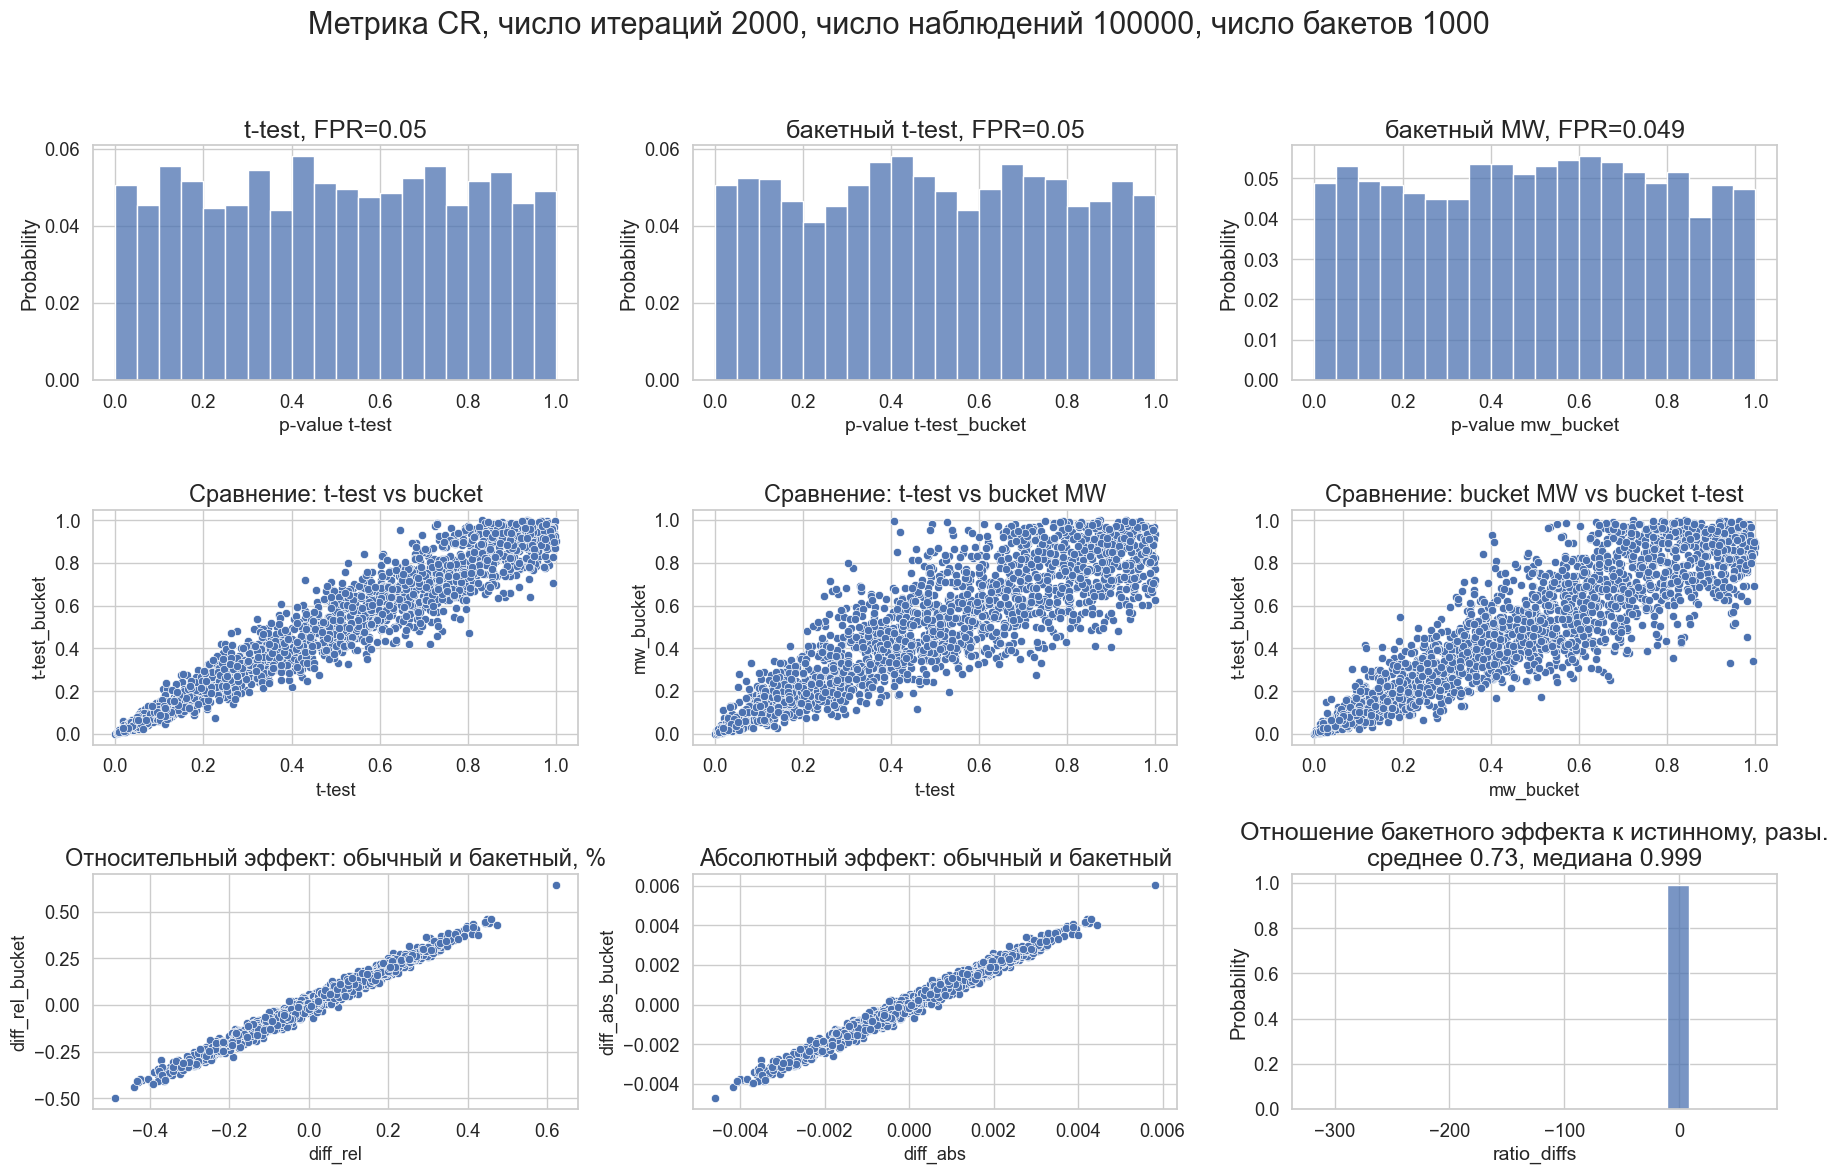

In [75]:
test_calc = StatTestCalc(n=100_000, n_bucket=1000, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'cr'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='CR', n=iterations)

# Проверка мощности
Сравним чувствительность 3 способов расчета: для этого в группу Б добавляется к каждому наблюдению эффект в виде константы. В качестве безлайна берется t-test - оценим, есть ли прирост мощности бакетных вариантов

* FRP тут это TPR, то есть мощность

100%|██████████| 2000/2000 [13:30:42<00:00, 24.32s/it]       


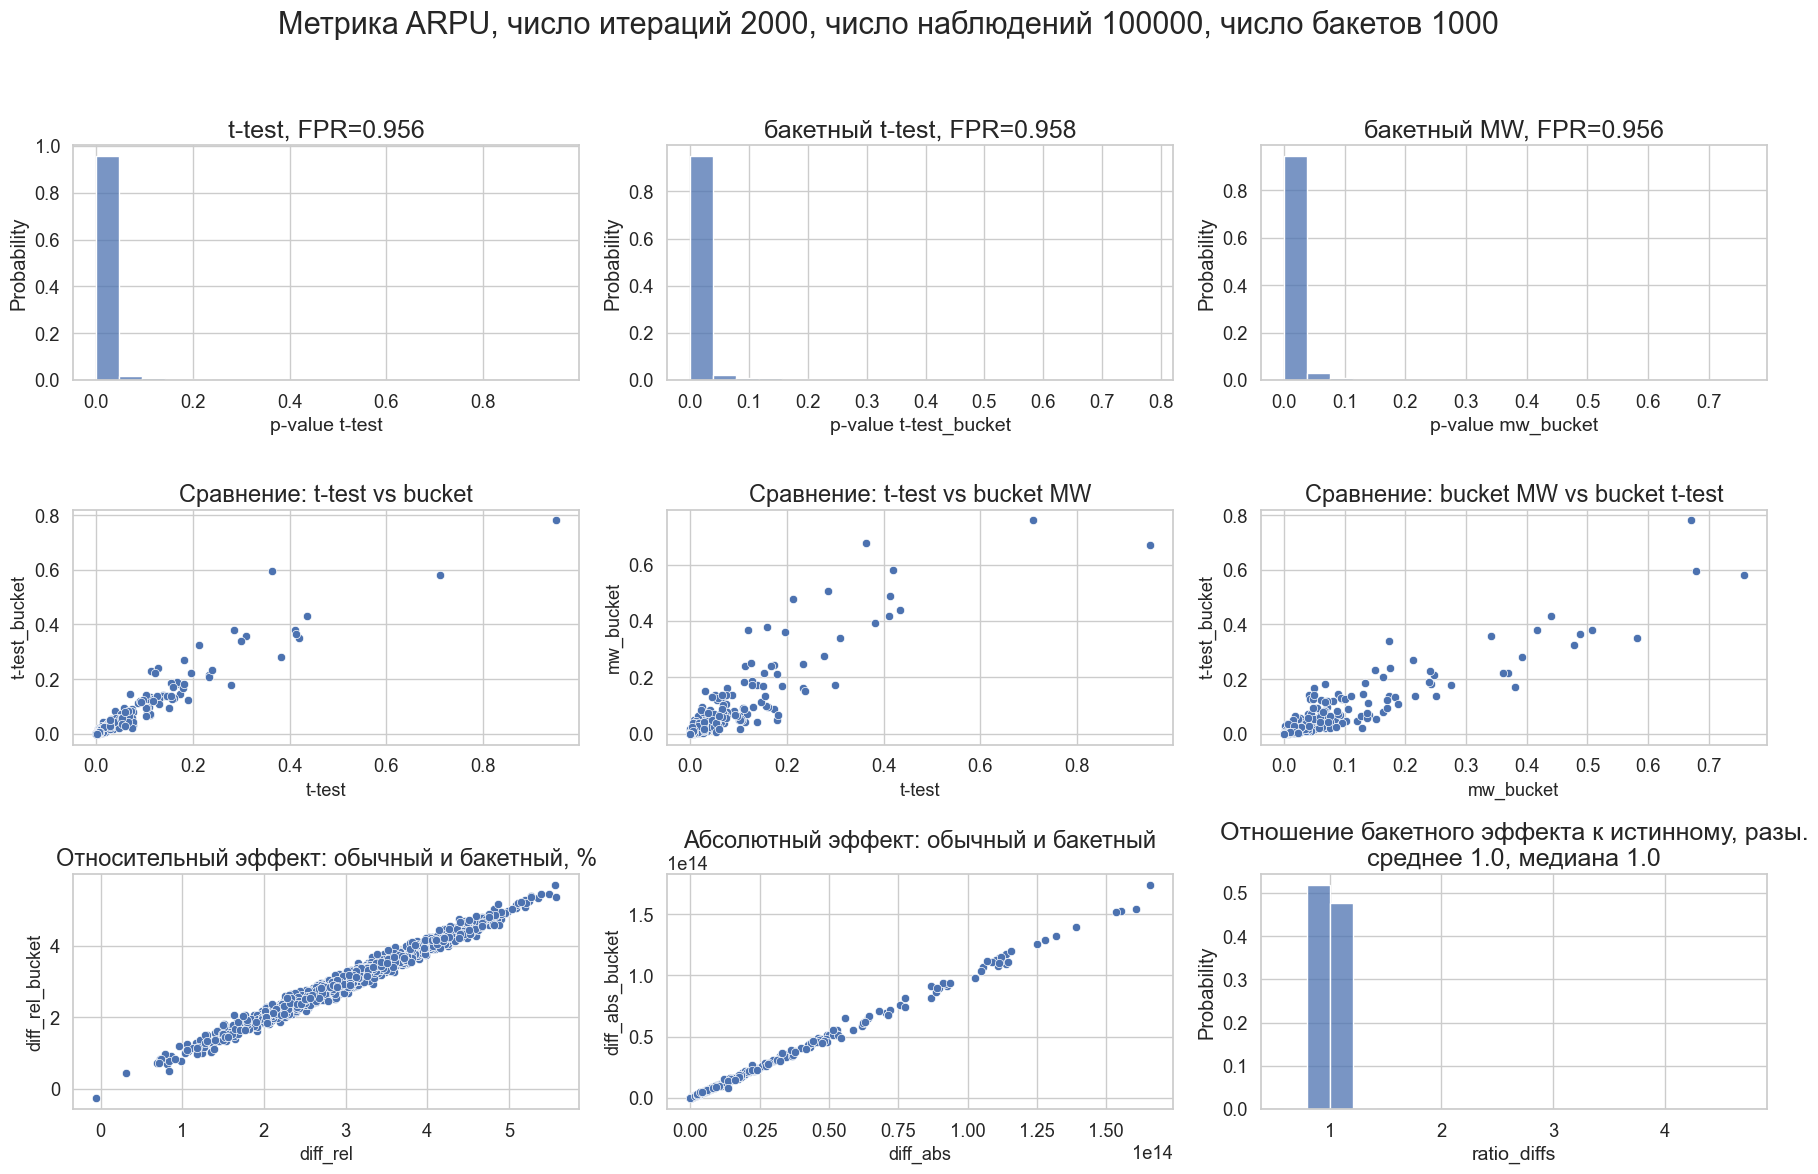

In [65]:
test_calc = StatTestCalc(n=100_000, n_bucket=1_000, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df['gmv'] = df.apply(lambda x: x['gmv'] * 1.03 if x['ab_group'] == 'b' else x['gmv'], axis=1)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

100%|██████████| 2000/2000 [5:31:50<00:00,  9.96s/it]  


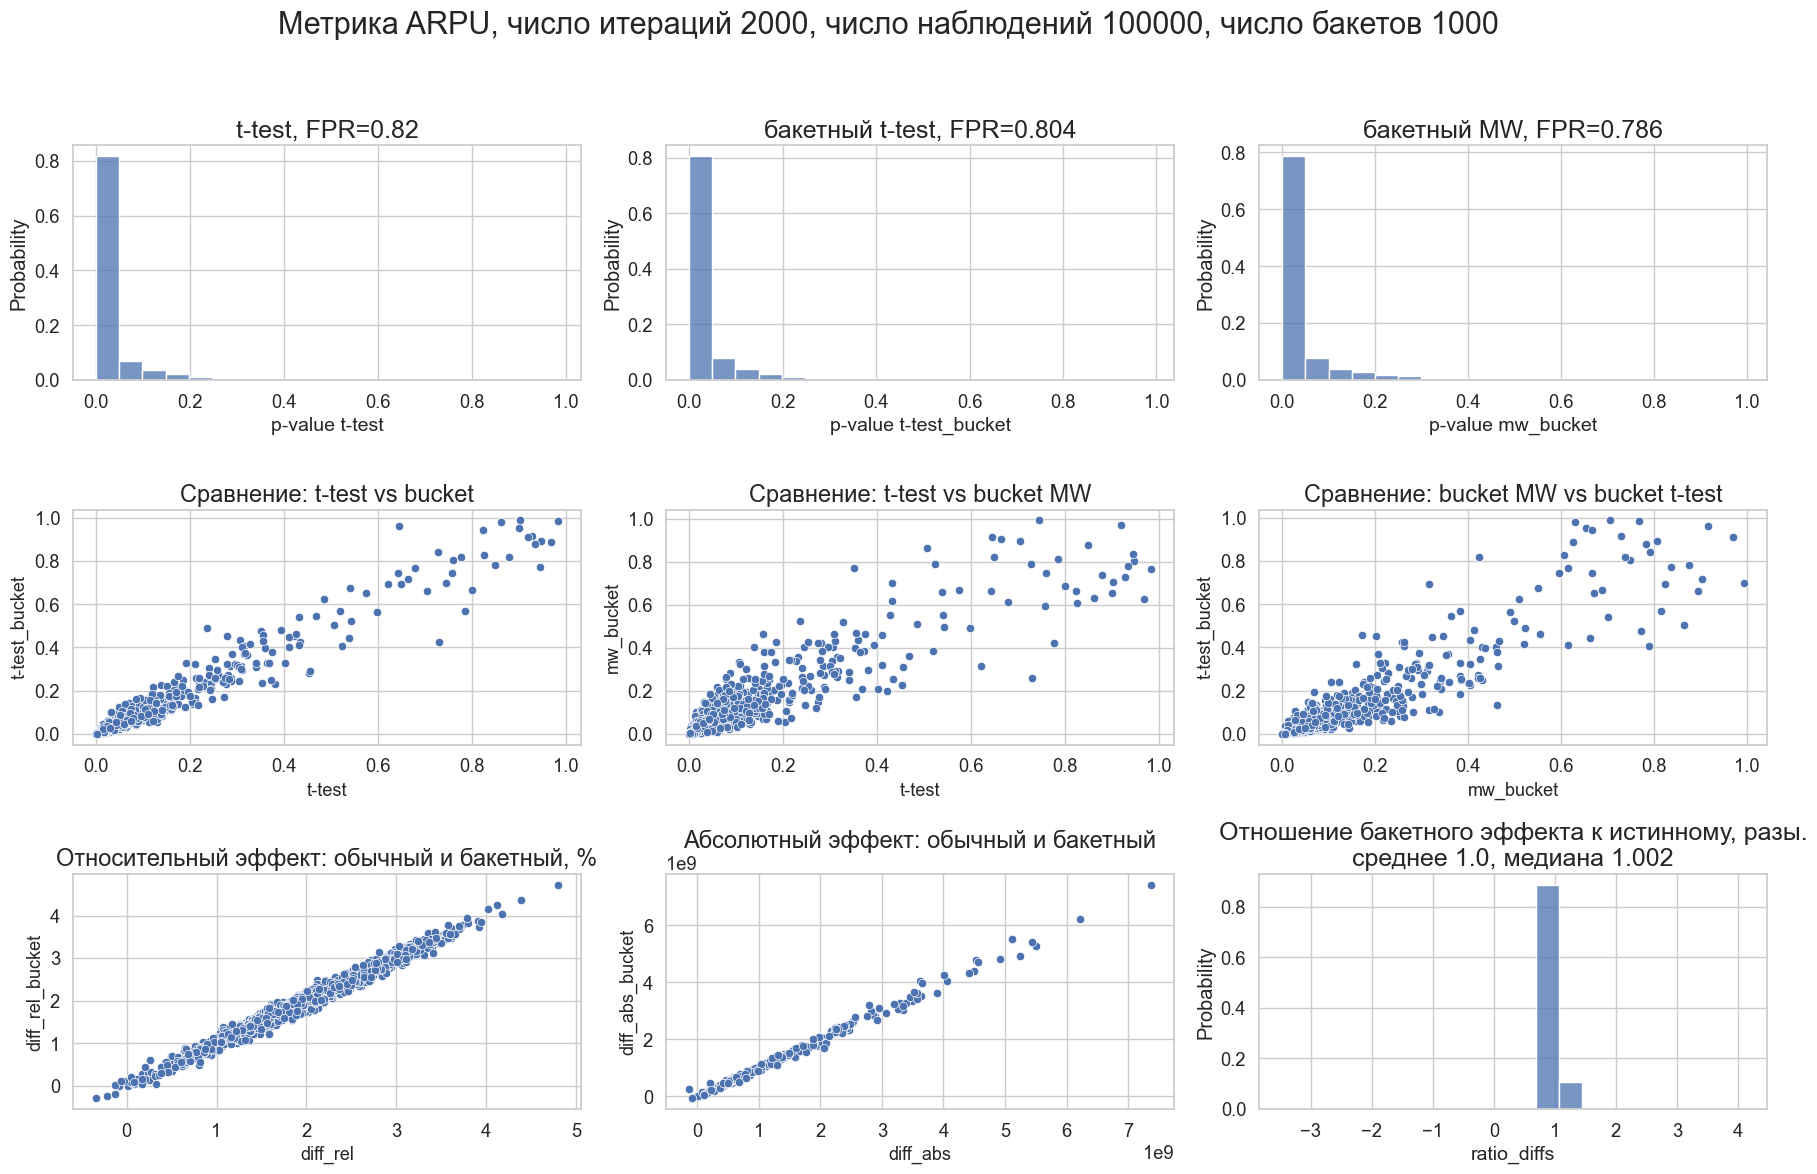

In [66]:
test_calc = StatTestCalc(n=100_000, n_bucket=1_000, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df['gmv'] = df.apply(lambda x: x['gmv'] * 1.02 if x['ab_group'] == 'b' else x['gmv'], axis=1)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

100%|██████████| 2000/2000 [5:40:44<00:00, 10.22s/it]  


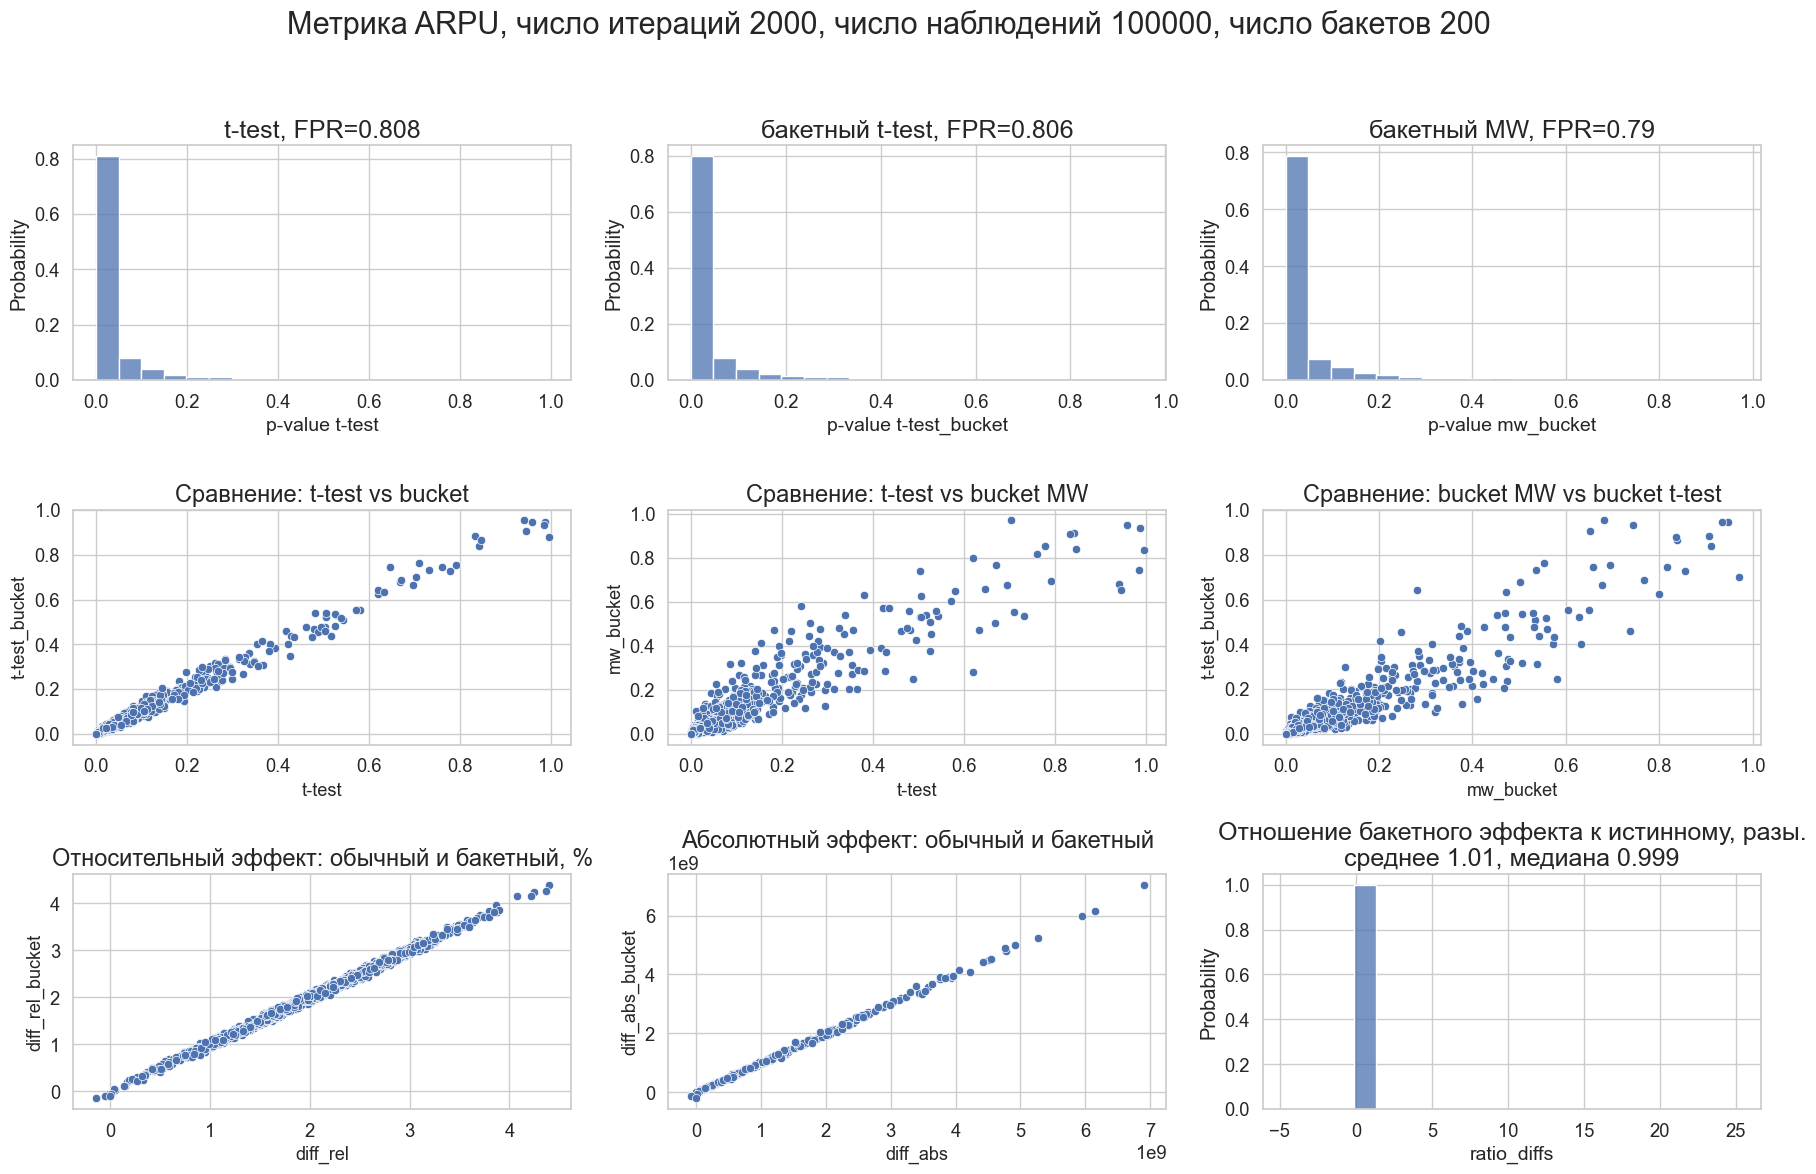

In [76]:
# уменьшим число бакетов до 200
test_calc = StatTestCalc(n=100_000, n_bucket=200, distribution='exp', mean=500)
df = test_calc.gen_dist()

results = []
for _ in tqdm(range(iterations)):
    df = test_calc.get_group(df)
    df['gmv'] = df.apply(lambda x: x['gmv'] * 1.02 if x['ab_group'] == 'b' else x['gmv'], axis=1)
    df = test_calc.get_bucket(df)
    results.append(test_calc.collect_stats(df, 'gmv'))
df_results = pd.DataFrame(results)

test_calc.plot_stats(df=df_results, metric='ARPU', n=iterations)

# Выводы

АА тесты:
- сонаправленность по p-value не наблюдается у всех критериев, что говорит о том, что проверяются разные гипотезы. Однако при увеличении числа наблюдений и перебора количества бакетов можно добиться приемлемой сонаправленности. Однако бакетные MW при любом числе бакетов будет несонаправлен с t-тестом.
- сонаправленность разности средних бакетов и без так же зависит от числа наблюдений/кол-ве бакетов. В теории так же можно подобрать оптимальное число бакетов, но с небольшой вероятнгостью будут наблюдаться сильные отклонения от истинного эффекта
- все вышеупомянутое справедливо как для непрерывных, так и для биномиальных метрик
- бакетный t-тест не справляется с выбросами, как и обычный t-тест. Бакетный MW справился, потому что проверяет позиции рангов бакетов, а не средние бакетов.

АБ тесты:
- мощность бакетных способов расчета остается на уровне обычного t-теста, увеличения не наблюдается. Возможно оно будет наблюдаться при гетерогенном эффекте
- так же при определенном отношении число наблюдений/число бакетов наблюдается хорошая сонавпраленность между обычным t-тестом и бакетным. В случае MW такого не наблюдается

Исходя из этого можно сделать вывод о том, что бакетный вариант t-теста ни в плане работы с выбросами, ни в плане мощности не лучше обычного t-теста. Бакетный Манна-Уитни тест ничем не лучше t-теста, потому что проверяет совсем другую гипотезу - позиции рангов бакетов. С точки зрения мощности так же прироста не наблюдалось.